# 02 - Data Preparation
* (1) 

In [24]:
import pandas as pd
import numpy as np
import scipy
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.signal import detrend, butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt
import utils
from constants import Constants

In [15]:
# Get a list of all accelerometer files
all_files = utils.get_all_files()

# Load one accelerometer data file into dataframe
load_id = 0     # Load the first CSV file from the file list 
file_id, df = utils.load_single_data(all_files, load_id)

# Setup paramters
fs = Constants.fs

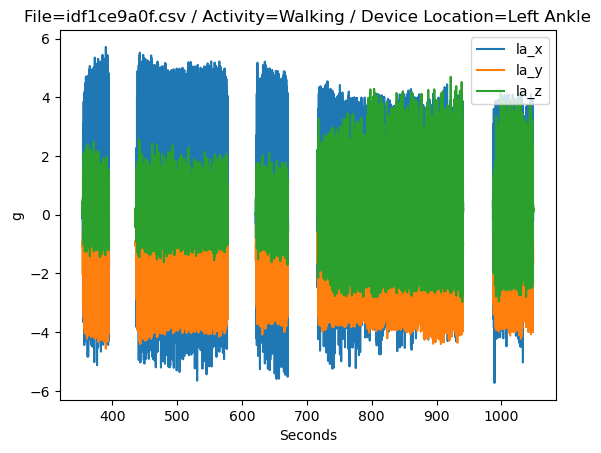

In [16]:
location_id = 'la'
activity = 1         # plot Activity=1 (Walking)

utils.plot_zoomin(file_id, df, activity, location_id)

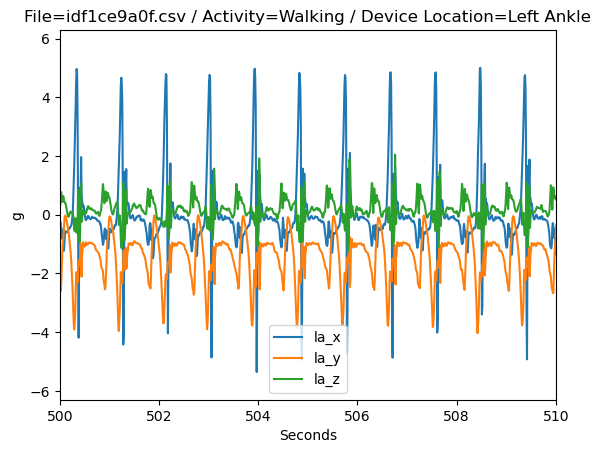

In [18]:
location_id = 'la'
activity = 1         # plot Activity=1 (Walking)
t0 = 500               # Begin second of the zoom-in plot
t1 = 510            # End second of the zoom-in plot

utils.plot_zoomin(file_id, df, activity, location_id, t0, t1)

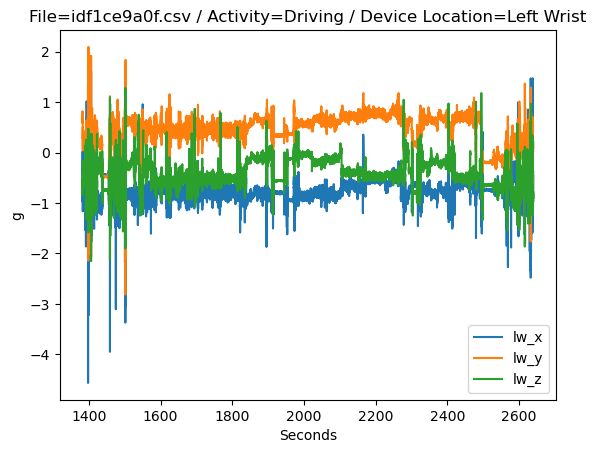

In [19]:
location_id = 'lw'
activity = 4         # plot Activity=1 (Walking)
t0 = 1600               # Begin second of the zoom-in plot
t1 = 1610            # End second of the zoom-in plot

utils.plot_zoomin(file_id, df, activity, location_id)

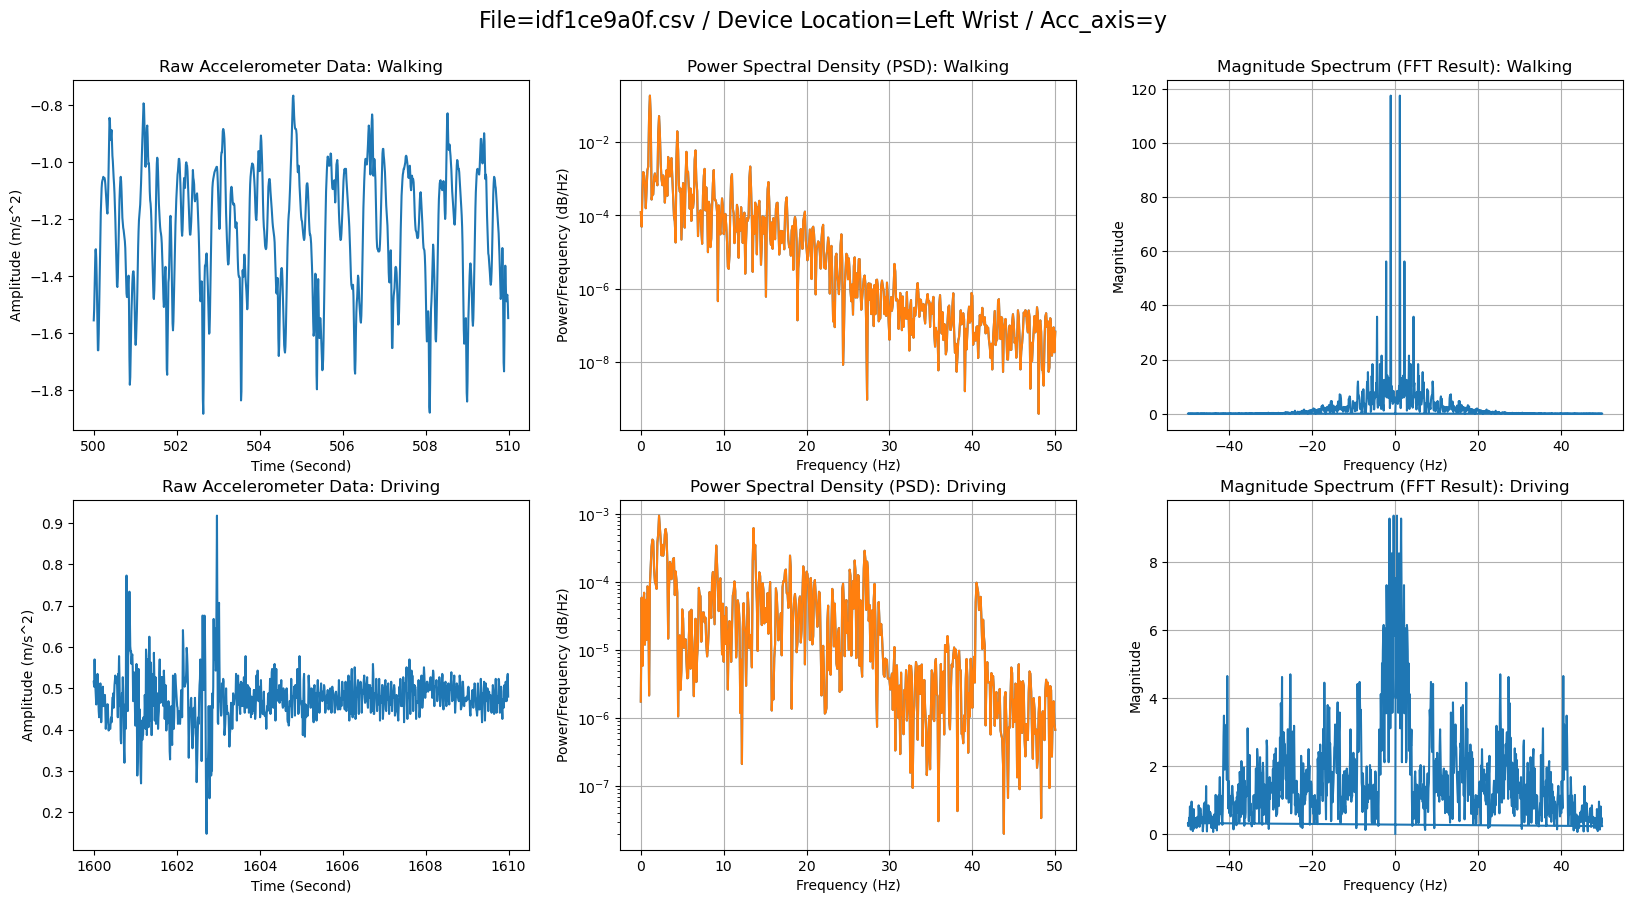

In [25]:
'''
Use frequency analysis to obtain steps counts
'''
def compute_psd(signal_data, fs=fs):    
    # Compute power spectral density using Welch's method
    signal_data = detrend(signal_data)  # Detrend to preven Spectral leakage 
    nperseg = 1024   # Set default as 1024; will use a smaller value if the input signal has fewer points 
    frequencies, psd = signal.welch(signal_data, fs, nperseg=min(nperseg, len(signal_data)))
    return frequencies, psd

def compute_fft(signal_data, fs=fs):
    # Compute FFT
    signal_data = detrend(signal_data) # Detrend to preven Spectral leakage
    fft_result = fft(signal_data)
    freq = fftfreq(len(signal_data), 1/fs)
    return freq, fft_result

def cut_data(df, location_id, activity, t0, t1):
    # Prepare 10-sec Walking data from Left ankle
    df2 = df[df.activity==activity]                      # Select Activity
    df2_cut = df2[(df2.time_s>=t0) & (df2.time_s<t1)]    # Cut to a segment
    loc_x = location_id+'_x'
    loc_y = location_id+'_y'
    loc_z = location_id+'_z'
    signal_data_t = df2_cut.time_s
    signal_data_x = df2_cut[loc_x]
    signal_data_y = df2_cut[loc_y]
    signal_data_z = df2_cut[loc_z]
    return signal_data_t, signal_data_x, signal_data_y, signal_data_z

# Begin to plot
fig = plt.figure(figsize=(20, 10))

device_location = 'la'  # left Ankle
acc_component = 'y'
device_location = utils.get_device_location(location_id)
title = file_id.split('/')[-1] 
fig.suptitle('File='+title+' / Device Location='+device_location+' / Acc_axis='+acc_component, fontsize=16, y=0.95)

# Data for Walking
activity = 1            # 1: Walking
activity_type = utils.get_activity_type(activity)
t0 = 500
t1 = 510

signal_data_t, signal_data_x, signal_data_y, signal_data_z = cut_data(df, location_id, activity, t0, t1)
if acc_component=='x':
    signal_data = signal_data_x
elif acc_component=='y':
    signal_data = signal_data_y
elif acc_component=='z':
    signal_data = signal_data_z
    
plt.subplot(2,3,1)
plt.plot(signal_data_t, signal_data)
plt.title('Raw Accelerometer Data: '+activity_type)
plt.xlabel('Time (Second)')
plt.ylabel('Amplitude (m/s^2)')

plt.subplot(2,3,2)
# Apply PSD with Scipy
frequencies, psd = compute_psd(signal_data, fs=fs)
plt.plot(frequencies, psd)
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD): '+activity_type)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.subplot(2,3,3)
# Apply FFT
freq, fft_result = compute_fft(signal_data.values, fs=fs)
plt.plot(freq, np.abs(fft_result))
plt.title('Magnitude Spectrum (FFT Result): '+activity_type)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)


# # Data for Driving
activity = 4            # 4: Driving
activity_type = utils.get_activity_type(activity)
t0 = 1600
t1 = 1610
signal_data_t, signal_data_x, signal_data_y, signal_data_z = cut_data(df, location_id, activity, t0, t1)
if acc_component=='x':
    signal_data = signal_data_x
elif acc_component=='y':
    signal_data = signal_data_y
elif acc_component=='z':
    signal_data = signal_data_z
    
plt.subplot(2,3,4)
plt.plot(signal_data_t, signal_data)
plt.title('Raw Accelerometer Data: '+activity_type)
plt.xlabel('Time (Second)')
plt.ylabel('Amplitude (m/s^2)')

plt.subplot(2,3,5)
# Apply PSD with Scipy
frequencies, psd = compute_psd(signal_data, fs=fs)
plt.plot(frequencies, psd)
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD): '+activity_type)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.subplot(2,3,6)
# Apply FFT
freq, fft_result = compute_fft(signal_data_x.values, fs=fs)
plt.plot(freq, np.abs(fft_result))
plt.title('Magnitude Spectrum (FFT Result): '+activity_type)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

In [34]:
'''
Apply filtering to remove target frequency range
'''


Text(0.5, 1.0, 'Filter Example: 30 Hz High-Pass')

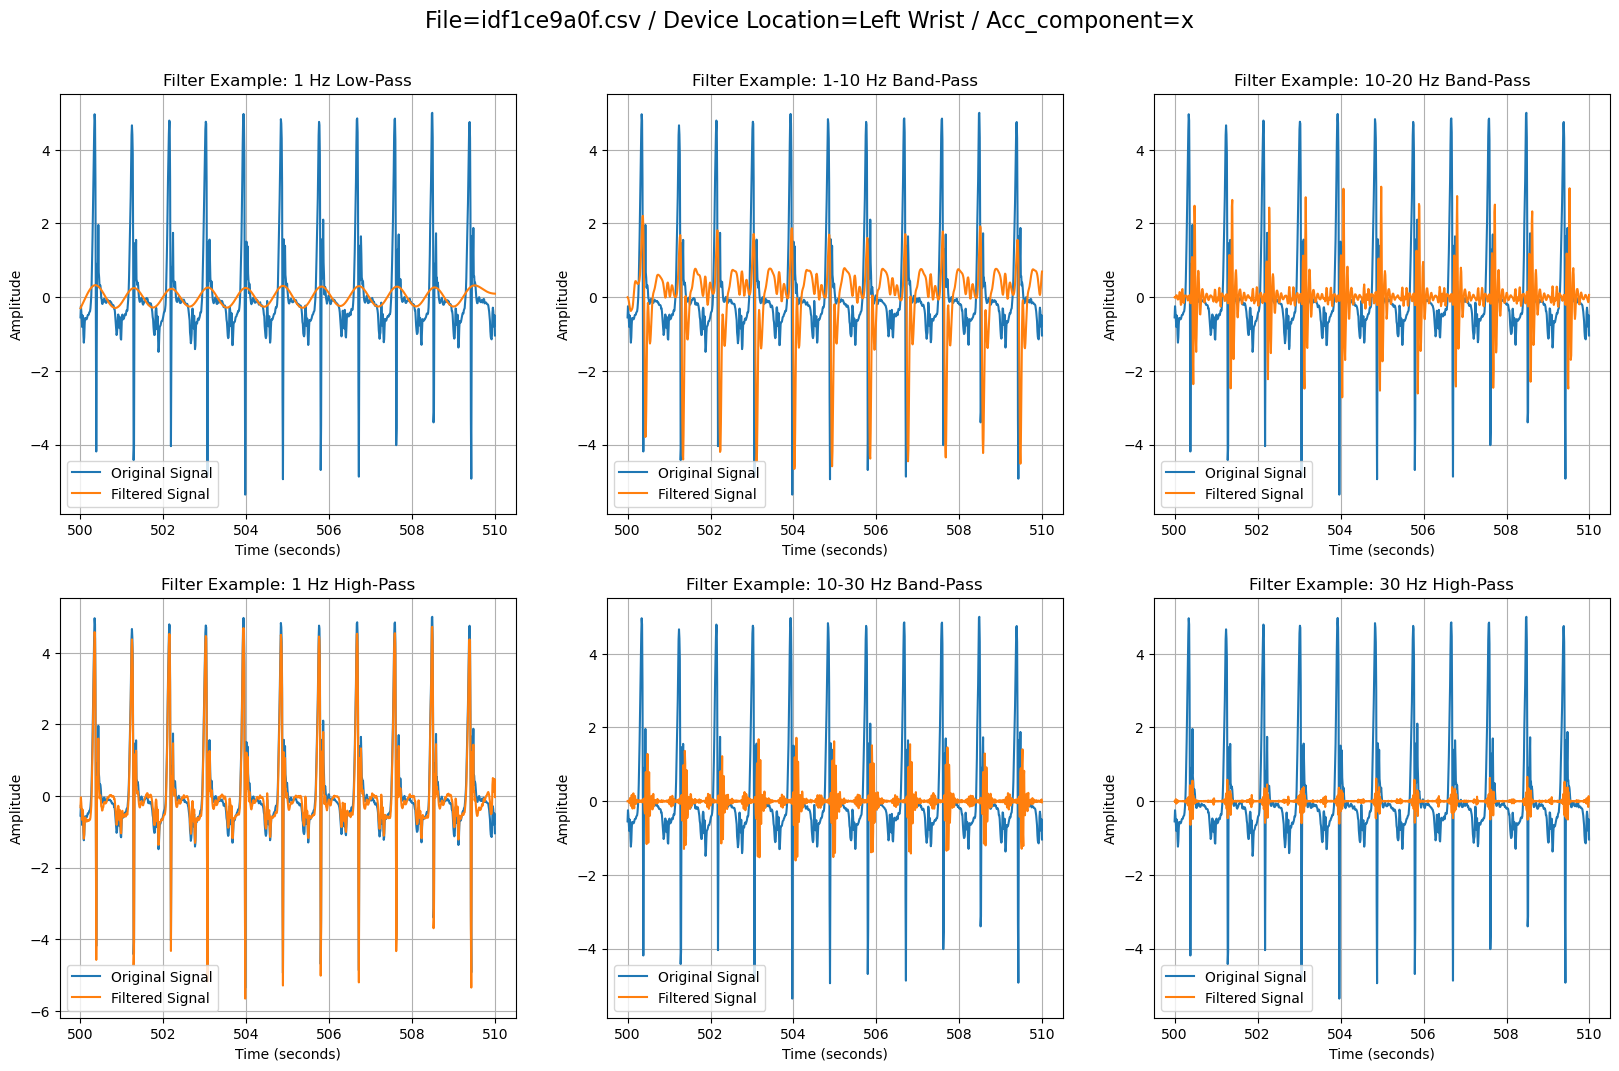

In [30]:
# Function to design a bandpass filter
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=4):
    # Design a Butterworth band-pass filter
    def butter_bandpass(lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a
    signal = detrend(signal)    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

def butter_highpass_lowpass_filter(signal, filter_type, cutoff_frequency, sampling_rate, order=4):
    # Design a Butterworth high-pass or low-pass filter
    # filter_type = 'high'  # for high-pass filter
    # filter_type = 'low'   # for low-pass filter
    signal = detrend(signal)
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    filtered_signal = filtfilt(b, a, signal)  # Apply the high-pass/low-pass filter to the signal
    return filtered_signal

device_location = 'la'  # left Ankle
activity = 1            # 1: Walking
t0 = 500
t1 = 510
signal_data_t, signal_data_x, signal_data_y, signal_data_z = cut_data(df, device_location, activity, t0, t1)

t = signal_data_t
acc_component = 'x'
if acc_component=='x':
    signal = signal_data_x
if acc_component=='y':
    signal = signal_data_y
if acc_component=='z':
    signal = signal_data_z    
order  = 4     # Filter order 

# Begin to plot
fig = plt.figure(figsize=(20, 12))
device_location = utils.get_device_location(location_id)
title = file_id.split('/')[-1] 
fig.suptitle('File='+title+' / Device Location='+device_location+' / Acc_component='+acc_component, fontsize=16, y=0.95)

def plot_filtered(t, signal, filtered_signal):
    plt.plot(t, signal, label='Original Signal')
    plt.plot(t, filtered_signal, label='Filtered Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

# Apply low-pass filter: 1 Hz
plt.subplot(2,3,1)
cutoff = 1     # Cutoff frequency for low-pass
filtered_signal = butter_highpass_lowpass_filter(signal, 'low', cutoff, fs, order=order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 1 Hz Low-Pass')

# Apply bandpass filter: 1 - 10
plt.subplot(2,3,2)
lowcut  = 1      # Lower cutoff frequency
highcut = 10     # Upper cutoff frequency
filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 1-10 Hz Band-Pass')

# Apply bandpass filter: 
plt.subplot(2,3,3)
lowcut  = 10     # Lower cutoff frequency
highcut = 20     # Upper cutoff frequency
filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 10-20 Hz Band-Pass')

# Apply high-pass filter: 1 Hz
plt.subplot(2,3,4)
cutoff = 1     # Cutoff frequency for high-pass
filtered_signal = butter_highpass_lowpass_filter(signal, 'high', cutoff, fs, order=order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 1 Hz High-Pass')

# Apply bandpass filter: 10 - 20
plt.subplot(2,3,5)
lowcut  = 20     # Lower cutoff frequency
highcut = 30     # Upper cutoff frequency
filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 10-30 Hz Band-Pass')

# Apply highpass filter: 30
plt.subplot(2,3,6)
cutoff = 30     # Cutoff frequency for high-pass
filtered_signal = butter_highpass_lowpass_filter(signal, 'high', cutoff, fs, order=order)
plot_filtered(t, signal, filtered_signal)
plt.title('Filter Example: 30 Hz High-Pass')